In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import cntk
from cntk import *

In [2]:
class Memory: 
    """
    Fixed capacity buffer implemented as circular queue
    Transitions are stored as (s, a, r, s') tuples
    """
    def __init__(self, capacity):
        self.samples = np.ndarray(capacity, dtype=object)
        self.capacity = capacity
        self.counter = 0
        self.flag = False
        
    def size(self):
        if self.flag:
            return self.capacity
        else:
            return self.counter
        
    def add(self, sample):
        self.samples[self.counter] = sample
        
        self.counter += 1
        if self.counter >= self.capacity:
            self.counter = 0
            self.flag = True
            
    def sample(self, n):
        n = min(n, self.size())
        
        size = self.size()
        if size < self.capacity:
            return np.random.choice(self.samples[:size], n)
        else:
            return np.random.choice(self.samples, n)

In [3]:
def moving_average(a, w=10):
    if len(a) < w:
        return a[:]
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]

In [4]:
def predict(Q, state):
    """
    Returns the values of all actions for the given state
    """
    return Q.eval([state.astype(np.float32)])

In [5]:
def epsilon_fn(episode, num_episodes):
    """
    Decays epsilon from 1 (at t = 0) to 0 (at t = 90% of T)
    """
    return -episode / (0.9 * num_episodes) + 1

In [6]:
def epoch_greedy(Q, state, episode, num_episodes):
    """
    Selects an action using the epoch-greedy approach
    """
    prob = np.random.randn(1)
    if prob > epsilon_fn(episode, num_episodes):
        # exploit (greedy)
        action_index = np.argmax(predict(Q, state))
    else:
        # explore (random action)
        action_index = np.random.randint(0, output_dim)
    
    return action_index

In [7]:
env = gym.make('CartPole-v0')

[2017-04-04 16:51:51,394] Making new env: CartPole-v0


In [8]:
input_dim = env.observation_space.shape
output_dim = env.action_space.n

input_var = input_variable(input_dim, np.float32)
output_var = input_variable(output_dim, np.float32)

model = Sequential([
    Dense(16, activation=relu, name='dense1'),
    Dense(16, activation=relu, name='dense2'),
    Dense(output_dim, name='z')
])(input_var)

In [26]:
loss = reduce_mean(square(model.z - output_var), axis=0)

learning_rate = 0.00025
lr_schedule = learning_rate_schedule(learning_rate, UnitType.sample)
learner = sgd(model.z.parameters, lr_schedule)
printer = cntk.logging.ProgressPrinter(tag='Training')
trainer = Trainer(model.z, loss, learner, printer)

In [27]:
# Parameters
gamma = 0.99
episodes = 20000
memory_capacity = 50000
minibatch_size = 32

In [28]:
# Create and initialize memory with randomly obtained sample transitions
samples = 0
memory = Memory(memory_capacity)
s = env.reset()

while samples < memory_capacity:
    # Select random action at each step
    a = np.random.randint(0, output_dim)
    
    s_, r, done, info = env.step(a)
    s_ = None if done else s_ # Track terminal states
    
    memory.add((s, a, r, s_))
    samples += 1
    
    s = s_
    
    if done:
        s = env.reset()

In [ ]:
# Train network
rewards = 0
episode = 0
reward_list = []

s = env.reset()
while episode < episodes:
    # Select action using policy derived from Q (e-greedy)
    a = epoch_greedy(model, s, episode, episodes)
    
    # Take action and observe next state and reward
    s_, r, done, info = env.step(a)
    s_ = None if done else s_ # Track terminal states
    
    # Store transition in memory
    memory.add((s, a, r, s_))
    
    # Sample random minibatch of transitions from memory
    batch = memory.sample(minibatch_size)
    
    # Calculate the values of the next states for each sample in the batch
    no_state = np.zeros(input_dim)
    next_states = np.array([no_state if sample[3] is None else sample[3] for sample in batch], dtype=np.float32)
    values = predict(model, next_states)
    
    # Calculate y_j for each sample in batch
    net_in = np.zeros((minibatch_size, input_dim[0]), dtype=np.float32)
    net_out = np.zeros((minibatch_size, output_dim), dtype=np.float32)
    
    for i in range(minibatch_size):
        S, a, r, S_ = batch[i]
        qa = values[0][i]
        
        if S_ is None:
            qa[a] = r
        else:
            qa[a] = r + gamma * np.amax(values[0][i])
        
        net_in[i] = S
        net_out[i] = qa
    
    # Perform a gradient descent step
    trainer.train_minibatch({input_var: net_in, output_var: net_out})
    
    s = s_
    rewards += r
    
    # Episode over, reset environment
    if done:
        episode += 1
        reward_list.append(rewards)
        
        if episode % 200 == 0:            
            trainer.summarize_training_progress()
            print('Episode {}, reward = {}\n'.format(episode, rewards))
            
        s = env.reset()
        rewards = 0

Finished Epoch[1 of 300]: [Training] loss = 4.914925 * 150720, metric = 0.00% * 150720 15.643s (9635.0 samples/s);
Episode 200, reward = 33.0

Finished Epoch[2 of 300]: [Training] loss = 5.663687 * 144960, metric = 0.00% * 144960 10.445s (13878.4 samples/s);
Episode 400, reward = 24.0



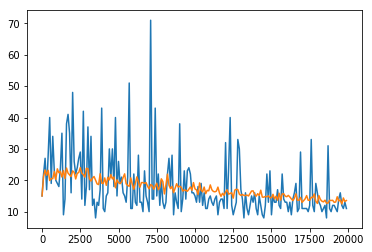

In [13]:
step = 100
x = range(0, episodes, step)
ave = moving_average(reward_list, w=50)[::step]
plt.plot(x, reward_list[::step])
plt.plot(x, ave)
plt.show()

In [25]:
import time

s = env.reset()
done = False
rewards = 0
while not done:
    env.render()
    a = np.argmax(predict(model, s))
    s, r, done, info = env.step(a)
    rewards += r
    time.sleep(1)
    
print('Total rewards = {}'.format(rewards))

Total rewards = 10.0


In [15]:
env.close()